# Jupyter GUI Automation Pilot

A Python-based framework for creating and running GUI automations using Jupyter Lab notebooks as an execution environment. The system allows for robust automation flows with built-in error recovery and state management.

## Overview

The Pilot class executes specially formatted Jupyter notebooks containing GUI automation steps. Each step is marked with a specific comment (`# comment: Automated step generated with pyPeriscope`) and can contain visual element detection and interaction code.

Key features:
- Step-by-step execution of automation sequences
- State preservation through PNG screenshots with embedded metadata
- Error recovery with the ability to resume from the last successful state
- Dynamic Scope adjustment for visual element detection

## Usage

```python
# Initialize the automation
pilot = Pilot("your_automation.ipynb", step_timeout=2)

# Run the complete automation
pilot.run_workbook()
```

## Recovery Process

If the automation fails, the system saves the state in a PNG file (`_your_automation.png`). To recover:

```python
# After adjusting Scope or making manual changes, continue from next step
pilot.run_workbook(firstStep=pilot.current_step + 1)
```

## Notebook Structure

The automation notebook requires:
|Cell Type|Requirement|Purpose|
|---------|-----------|-------|
|__Scope Cells__|First line contains ```# comment: Automated step...```|Step separation points|
|__Markdown Cells__|Any documentation|Preserved in current_doc state|
|__Code Cells__|Standard Python between markers|Action implementations|

```python
# cell 1 - Standard imports (as 1st thing to make all imports)
from pyperiscope import Scope, Pilot

# cell 2 - MD format readme what is the step doing
# 1. Create new document

# cell 3 - First automation step (marker required)
# comment: Automated step generated with pyPeriscope V2
payload = '''...serialized scope data...'''
step = Scope(saved_dict=dill.loads(codecs.decode(payload.encode(), 'base64')))

# cell 4 - Step actions
step.find(tries=3, confidence=0.85)
    pyautogui.click(step.get_locations()[0])
```
The system executes code between marker cells as individual automation steps, managing the flow automatically.

## Technical Details

The Pilot maintains the execution state, including error information, documentation content, and Scope cell identification. When saving state, it preserves current step information, error details, and visual detection parameters, enabling precise recovery and adjustment of the automation flow.

Split to steps and view content of Automation workbooks
===============================================
[layer1](http://localhost:8888/lab/tree/Documents/git2/Pyperiscope/src/pyperiscope/pilot/layer1.py)

1. Needs to split the wrokbook into steps
2. Get and view specific cells from the workbook

In [1]:
import pickle
import json
import nbformat
import os
from PIL import Image
from PIL.PngImagePlugin import PngInfo
from pyperiscope import Scope

class Pilot():
    def __init__(self, workbook, step_timeout=1):
        self.current_notebook = workbook
        self.steps = []
        self.current_step = -1
        self.steps_total = -1
        self.current_doc = ""
        self.last_run_code = ""
        self.last_error = ""
        self.scope_cell_id = -1
        self.step_timeout = step_timeout
        
        self.get_steps()

    # load the steps form automation workbook for fruthert usage
    def get_steps(self):
        with open(self.current_notebook, 'r', encoding='utf-8') as f:
            notebook = json.load(f)
        
        # Find all cells with the marker comment
        marker_cells = []
        for i, cell in enumerate(notebook['cells']):
            if cell['cell_type'] == 'code' and cell['source']:
                if cell['source'][0].find("# comment: Automated step generated with pyPeriscope")>-1:
                    marker_cells.append(i)
        
        if not marker_cells:
            self.steps_total = -1
            print("No marker cells found, are you sure this is the correct jupyter lab notebook?")
            return
        
        # Create step ranges
        self.steps = []
        # First step: from start to first marker
        self.steps.append((0, marker_cells[0]-1))
        
        # Middle steps: between markers
        for i in range(len(marker_cells)-1):
            self.steps.append((marker_cells[i]-1, marker_cells[i+1]-1))
        
        # Last step: from last marker to end
        if marker_cells:
            self.steps.append((marker_cells[-1]-1, len(notebook['cells'])))
    
        # Make the 1st two into one as there are some imports in front
        self.steps = self.steps[1:]
        self.steps[0] = (0,self.steps[0][1])
        
        self.steps_total = len(self.steps)

    # read one cell worth of data
    def get_cell(self, cell_number):
        with open(self.current_notebook, 'r', encoding='utf-8') as f:
            notebook = json.load(f)
        
        code_cells = [cell for cell in notebook['cells']]
        
        if cell_number < 0 or cell_number >= len(code_cells):
            raise ValueError(f"Cell number must be between 0 and {len(code_cells) - 1}")
        
        return code_cells[cell_number]

    # simplified view cell (remove hs object defintions and outputs, use for debug)
    def view_cell(self, cell_number):
        code = self.get_cell(cell_number)
        if 'source' in code:
            if code['source'][0].find("# comment: Automated step") > -1:
                code['source'][1] = 'payload = \'*** removed for view ***\''
        if 'outputs' in code:
            if len(code['outputs']) > 0:
                code['outputs'] = ['*** removed for view ***']
        
        return(code)

Save and edit functionality
===============================================
[layer2](http://localhost:8888/lab/tree/Documents/git2/Pyperiscope/src/pyperiscope/pilot/layer2.py)

1. Save state with the screenshot
2. Overwrite the Scope deffinition in the original workbook - mend the automation if broken
3. Remove the previous state image to cleanup

In [ ]:
class Pilot(Pilot):
    # save screenshot with step and data
    def save_screenshot_with_data(self, screenshot, step, step_no):
        data_dict = {}
        # save the step dict
        data_dict['step'] = step.save_dict()
        data_dict['last_found'] = step.found_locations
        # save current step
        data_dict['current_step'] = self.current_step
        # save last error
        data_dict['last_error'] = self.last_error
        # last step scope cell id
        data_dict['scope_cell_id'] = self.scope_cell_id
        # docstring into saved png
        data_dict['current_doc'] = self.current_doc
        
        metadata = PngInfo()
        # Convert dict to bytes using pickle
        serialized_data = pickle.dumps(data_dict)
        # Store in PNG metadata with custom key
        metadata.add_text("custom_data", serialized_data.hex())
        screenshot.save("_"+self.current_notebook[:-6]+"-"+str(step_no)+".png", "PNG", pnginfo=metadata)

    # replace the scope object in the current step
    def replace_scope(self, scope_in):
        with open(self.current_notebook, 'r', encoding='utf-8') as f:
            nb = nbformat.read(f, as_version=4)
        
        # Find and edit the cell with matching ID
        for cell in nb.cells:
            if cell.get('id') == self.scope_cell_id:
                cell.source = scope_in.get_string()
                break
        
        with open(self.current_notebook, 'w', encoding='utf-8') as f:
            nbformat.write(nb, f)

    # delete previous workbook
    def del_previous(self, current):
        if current > 0:
                previous_file = "_" + self.current_notebook[:-6] + "-" + str(current - 1) + ".png"
                if os.path.exists(previous_file):
                    os.remove(previous_file)

Running functionality
===============================================
[layer3](http://localhost:8888/lab/tree/Documents/git2/Pyperiscope/src/pyperiscope/pilot/layer3.py)

1. Run any python code, specifiaclly one found in the workbook cell
2. Run specific cell by cell index
3. Run multiple cells that make up single Automation step
4. Run the entire workbook

In [ ]:
class Pilot(Pilot):
    # run the steps in global namespace so it would work like running the worksheet on the worksheet
    def run_code(self, code_str):
        self.last_run_code = code_str
        current_globals = globals()  # Get fresh globals each time
        exec(code_str, current_globals)

    # run single cell from notebook
    def run_cell(self, cell_number):
        self.last_error = None
        # get cell content
        current_cell = self.get_cell(cell_number)
        # if docstring cell update the variable
        if not current_cell['cell_type'] == 'code':
                if current_cell['cell_type'] == 'markdown':
                    content = "".join(current_cell['source'])
                    self.current_doc = self.current_doc + content
                else:
                    print("cell in not excecutable in 'code' mode, current mode: "+str(current_cell['cell_type']))
                return
        # join code into single string from line list
        current_code = "".join(current_cell['source'])
        # if the cell contains scope deffintion
        if current_code.find("# comment: Automated step") > -1:
            self.scope_cell_id = current_cell['id']
        # remove render preview
        code = current_code.replace("step.render_preview()\n","")
        # after all run the code
        try:
            self.run_code(code)
        except Exception as e:
            self.last_error = e
        # stop if there was an error
        if self.last_error:
            return

    # run one step end to end
    def run_step(self, step_no):
        print("Staring step: " + str(step_no))
        self.current_doc = ""
        current_screenshot = pyautogui.screenshot()
        for active_cell in range(self.steps[step_no][0], self.steps[step_no][1]):
            self.current_step = step_no
            self.run_cell(active_cell)
            if self.last_error:
                print(self.last_error)
                break
        self.save_screenshot_with_data(current_screenshot, step, step_no)

    # select and run a workbook
    def run_workbook(self, firstStep = -1):
        # run all the steps in the workbook
        for step in range(0, len(self.steps)):
            # if the workflow broke donw the continue from the last step
            if firstStep > 0:
                if firstStep == step:
                    firstStep = -1
                else:
                    continue
            # run the indivdual step
            self.run_step(step)  
                    
            # if error then stop, error is printed in the step process
            if self.last_error:
                return

            # cleanup the previous step and use timeout
            self.del_previous(step)    
            time.sleep(self.step_timeout)
        # delete the last log image if all was sucessfull
        self.del_previous(len(self.steps)) 

In [2]:
autorunner_pilot = Pilot("dav_subtitle2.ipynb")

In [67]:
autorunner_pilot.run_workbook()

found: 1
found: 1
found: 1
found: 1
found: 1


In [3]:
autorunner_pilot.run_step(0)

Could not locate the image (highest confidence = 0.511)


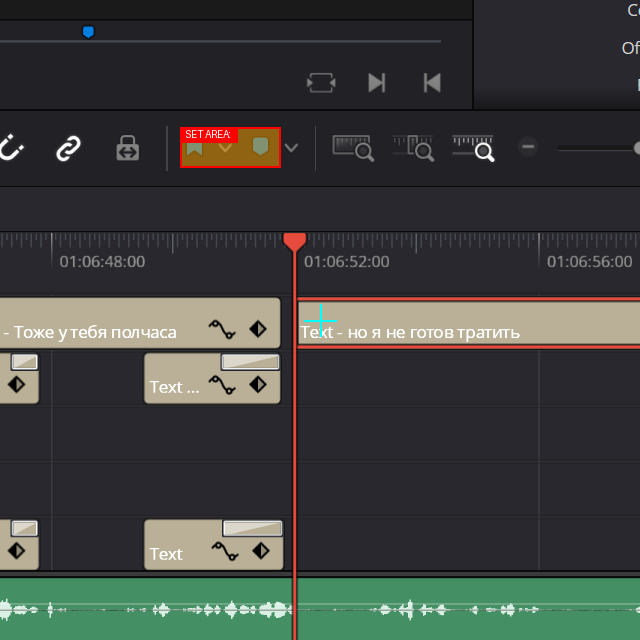

In [5]:
step.render_preview()

In [52]:
autorunner_pilot.replace_scope(stepx)